# Проект: Выбор локации для скважины

[yandex_practicum](https://practicum.yandex.ru/trainer/data-scientist/lesson/8a38c35b-48c6-42af-b7ab-00ca6786d6bb/)

## Описание проекта

Сотрудникам добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. 

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;

- Определяют регион с максимальной суммарной прибылью отобранных скважин.

В исходных данных предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. 
1) Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. 

2) Проанализируйте возможную прибыль и риски техникой Bootstrap.

### Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Описание данных

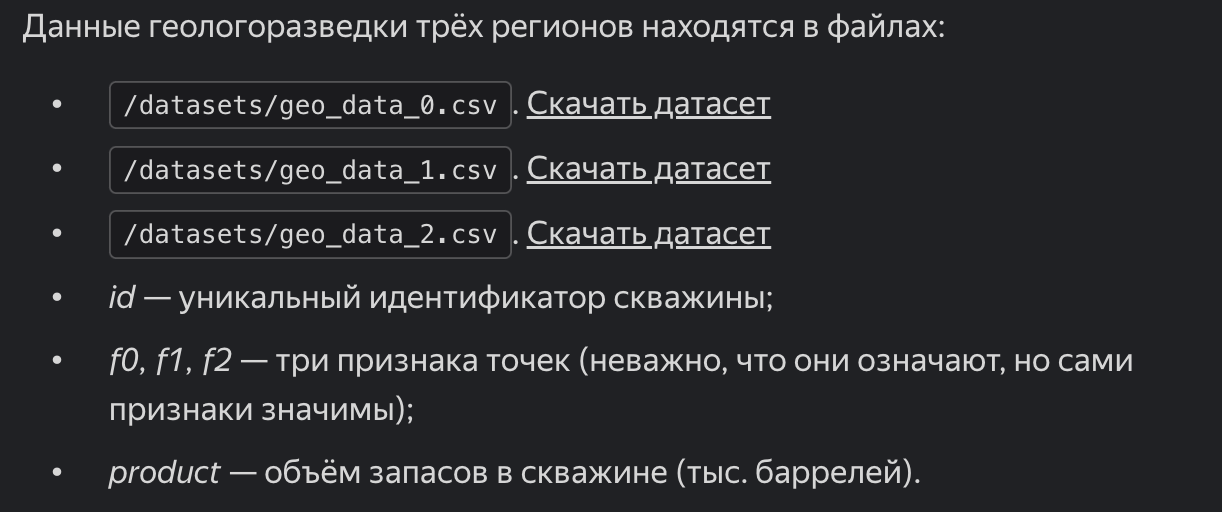

## Нужные библиотеки и загрузка данных

In [1]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

# библиотека для оценки корреляции
from phik import phik_matrix

# библиотека для оценки важности признаков Шепли (SHAP)
import shap

# бибилотеки для подготовки данных
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   PolynomialFeatures, 
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder)

from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE


# библиотеки для пайплайнов
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# класс для работы с пропусками
from sklearn.impute import SimpleImputer

# библиотеки для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score, make_scorer



# добавим библиотеку для построения scatter диаграмм рассеяния с тренд-линиями
import plotly.express as px 
import plotly.graph_objects as go



Читаем исходные датасеты:

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except FileNotFoundError:
    data_0 = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/10_ml_business/data/geo_data_0.csv')
    data_1 = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/10_ml_business/data/geo_data_1.csv')
    data_2 = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/10_ml_business/data/geo_data_2.csv')

In [3]:
# функция получения имени датасета

def get_dataset_name(variable):
    import inspect
    frame = inspect.currentframe()
    for scope in [frame.f_back.f_globals, frame.f_back.f_locals]:
        for var_name, var_val in scope.items():
            if isinstance(var_val, pd.DataFrame) and var_val is variable:
                del frame
                return var_name

In [4]:
# функция выбора цвета для текста output 

from IPython.display import Markdown, display

def print_red(text):
    display(Markdown(f'<span style="color:red">{text}</span>'))

In [9]:

for i in range(3):
    df = globals()[f"data_{i}"]
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals
    dataset_name = get_dataset_name(df)


    print_red(f'Информация по таблице {dataset_name} (Регион № {i})')
    display(df.head())
    print()
    display(df.info())
    print()
    print(f'Число дубликатов в таблице {dataset_name} = {df.duplicated().sum()}')
    

<span style="color:red">Информация по таблице data_0 (Регион № 0)</span>

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Число дубликатов в таблице data_0 = 0


<span style="color:red">Информация по таблице data_1 (Регион № 1)</span>

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Число дубликатов в таблице data_1 = 0


<span style="color:red">Информация по таблице data_2 (Регион № 2)</span>

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Число дубликатов в таблице data_2 = 0


Вывод: данные прочитаны, отсмотрены. Пустых значений нет, типы данных соответствуют наполнению, дубликатов нет. 

Перед завершением раздела утащим id в индексы

In [10]:
for i in range(3):
    df = globals()[f"data_{i}"]

    df.set_index('id', inplace=True)
    display(df.head())
    print()

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


## Работа с данными

### Анализ данных

Создадим 3 функции:

- вытягивания имени из переменной (для корректного наименования графиков)
- построения гистограммы и boxplot для количественных признаков

- сборная функция построения всей аналитики для любого датасета

In [11]:
# функция получения имени переменной

def get_var_name(var, caller_locals):
    import inspect
    for name, value in caller_locals.items():
        if value is var:
            return name
    return None

In [12]:
# функция для построения гистограммы и boxplot для любого столбца любого датафрейма

def plot_hist_boxplot(some_df, col, col_name, dataset_name):

    df_for_plot= some_df[col]

    # Рассчитываем квартили
    q25, q75 = df_for_plot.quantile(0.25), df_for_plot.quantile(0.75)
    min_val = int(q25- 1.5*(q75-q25))
    max_val= int(q75 +  1.5*(q75-q25))

    # Создаем новый график
    plt.figure(figsize=(10, 10))

    # Строим гистограмму
    plt.subplot(2, 1, 1)  # 2 строки, 1 столбец, график 1
    plt.hist(df_for_plot, bins=20, range=(min_val, max_val))
    plt.title(f'Гистограмма для признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'значения признака {col_name}')
    plt.ylabel(f'Частота')


    # Помечаем квартили на гистограмме
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()

    # Строим график boxplot
    plt.subplot(2, 1, 2)  # 2 строки, 1 столбец, график 2
    plt.boxplot(df_for_plot, vert=False)
    plt.title(f'Boxplot признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'Значение признака {col_name}')

    # Помечаем квартили на boxplot
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()


    # Показываем графики
    plt.tight_layout()  # Для автоматического выравнивания графиков
    plt.show()


        

In [14]:
# функция получения аналитических данных для любой таблицы

def analysis_df(some_df: pd.DataFrame, num_list: list):
    # блок вытягивания имени
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals

    dataset_name = get_var_name(some_df, caller_locals)
    

    print_red(f'Статистический анализ таблицы {dataset_name}')  # печатаем имя таблицы (из переменной)
    display(some_df.describe().T)

    # блок построения гистограмм и диаграмм

    for col in num_list:
        plot_hist_boxplot(some_df=some_df, col_name=col, col=col, dataset_name=dataset_name)


У нас только количественные данные, поэтому сомтреть будем только на гистограммы и boxplot:


<span style="color:red">Статистический анализ таблицы data_0</span>

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


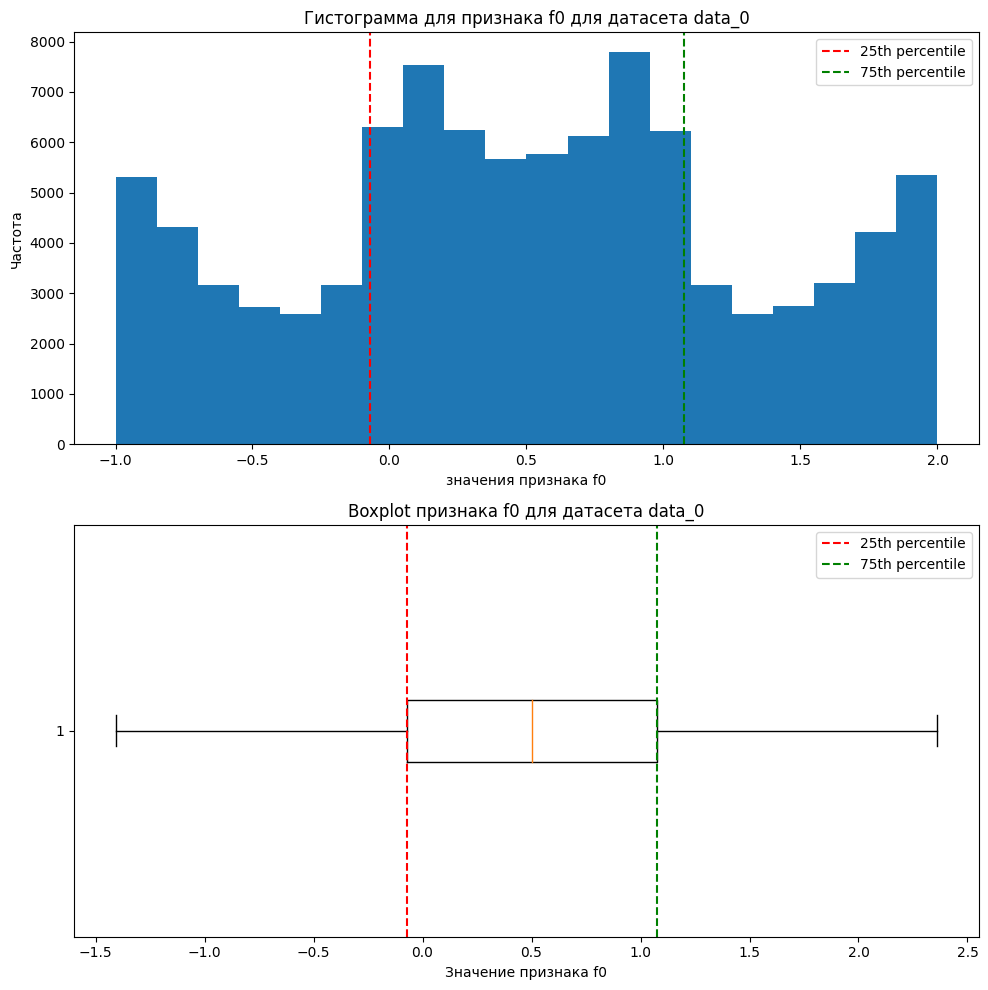

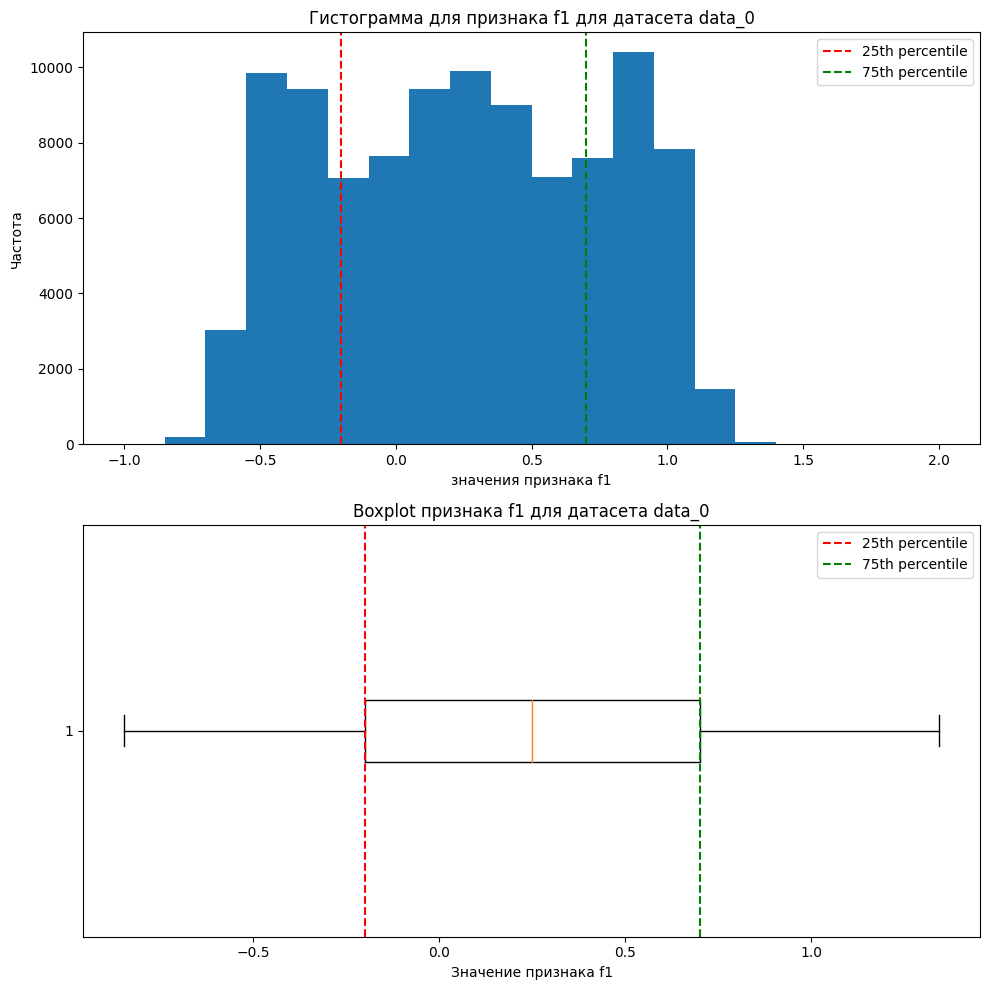

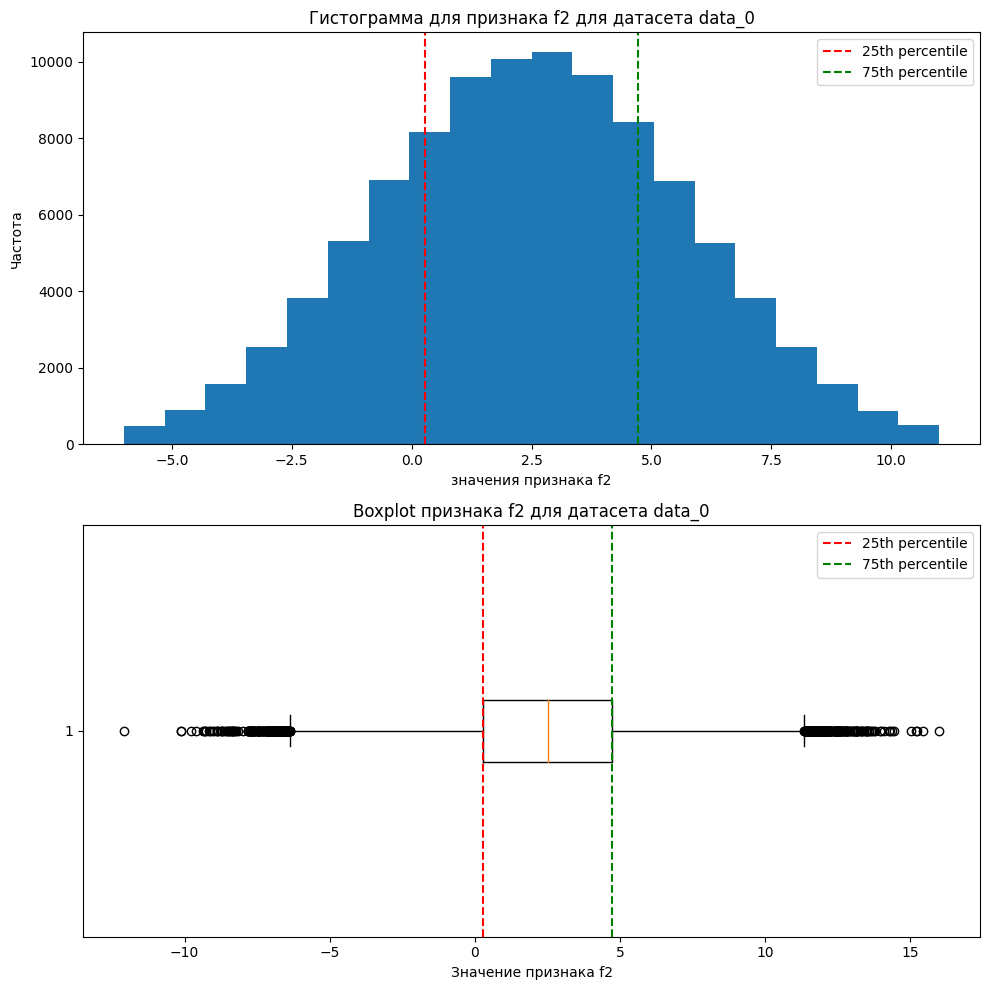

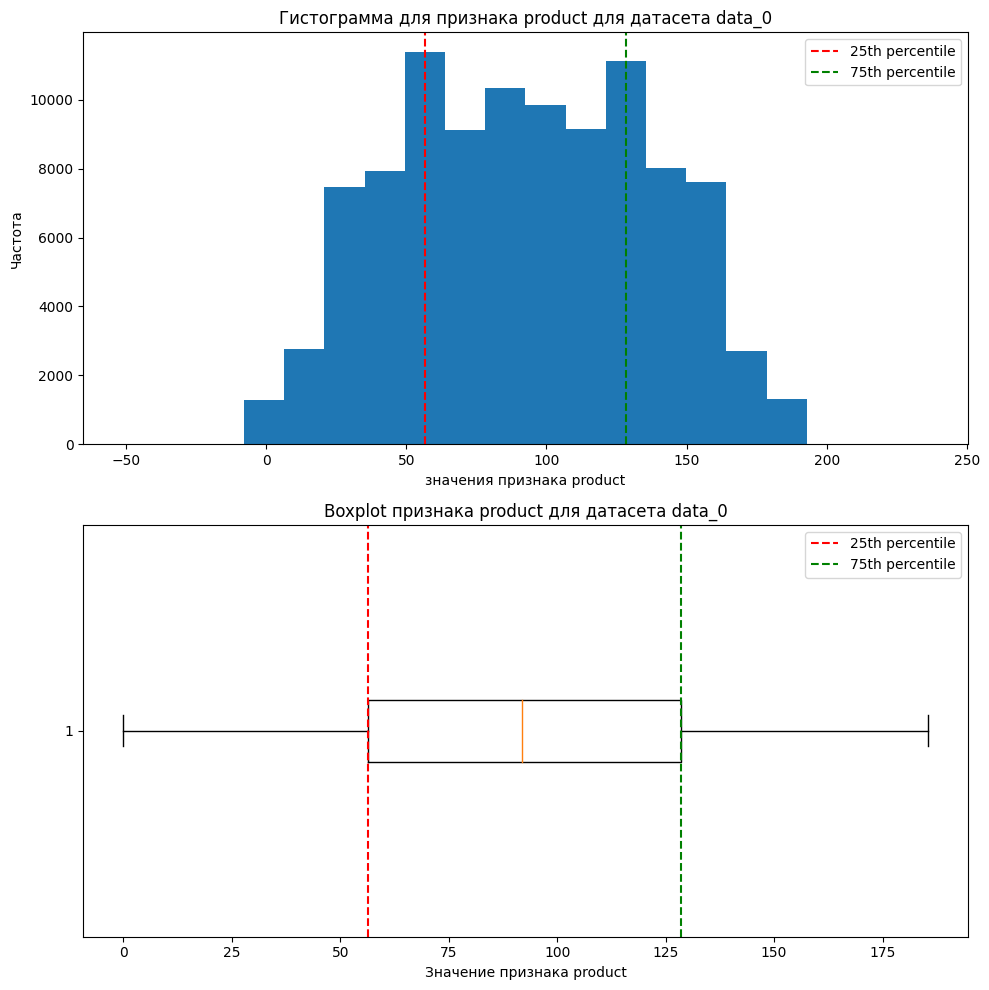

<span style="color:red">Статистический анализ таблицы data_1</span>

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


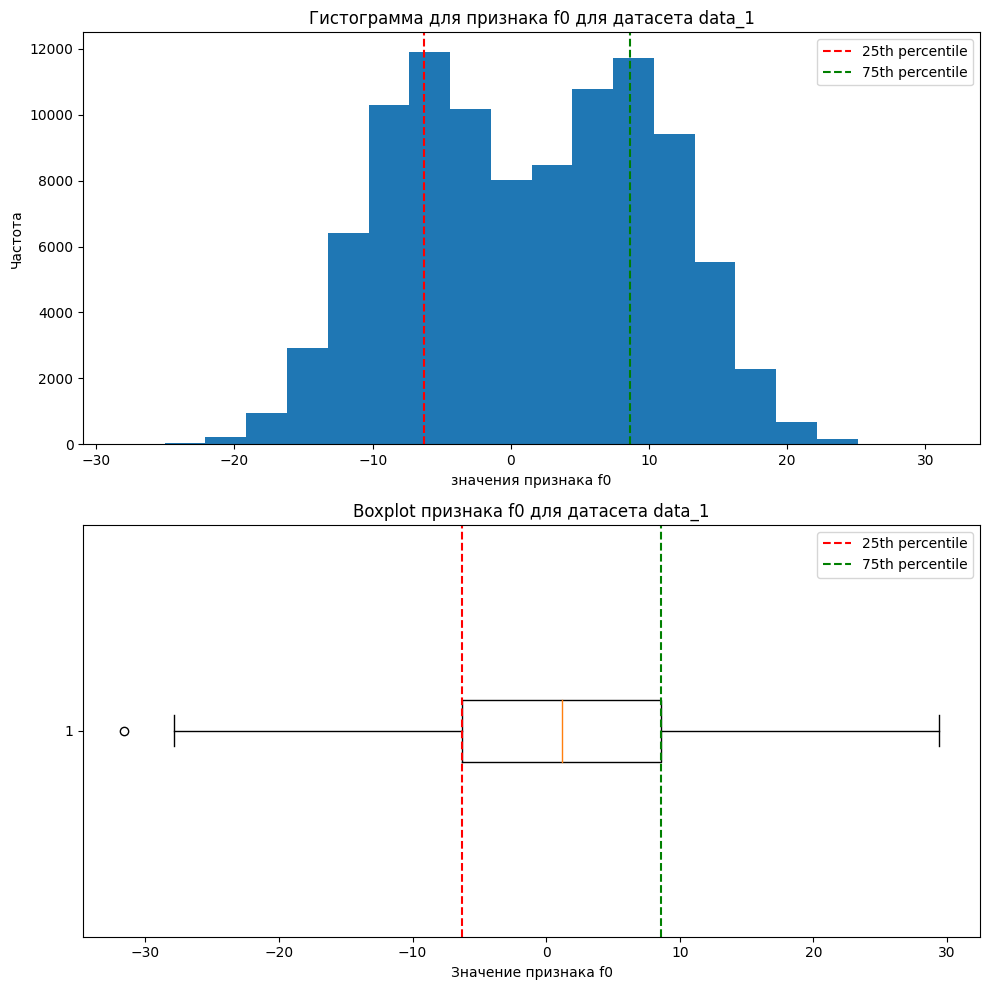

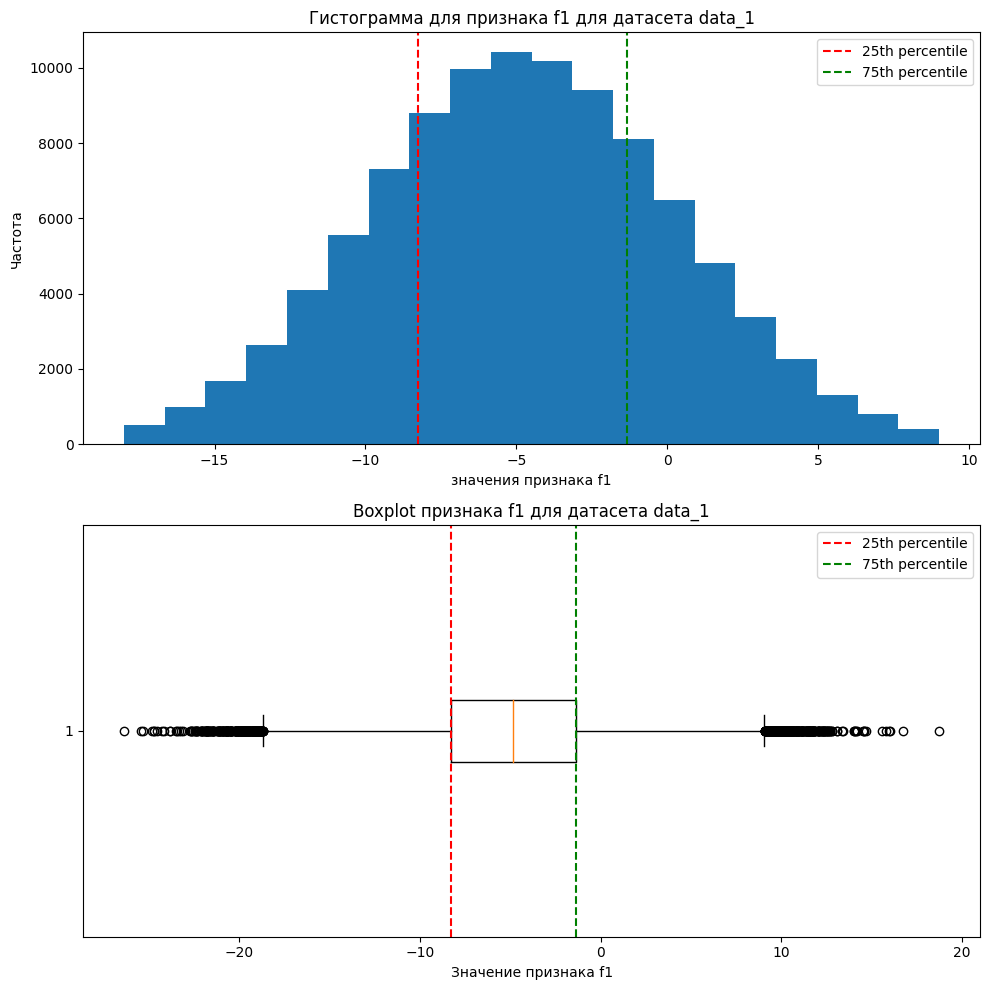

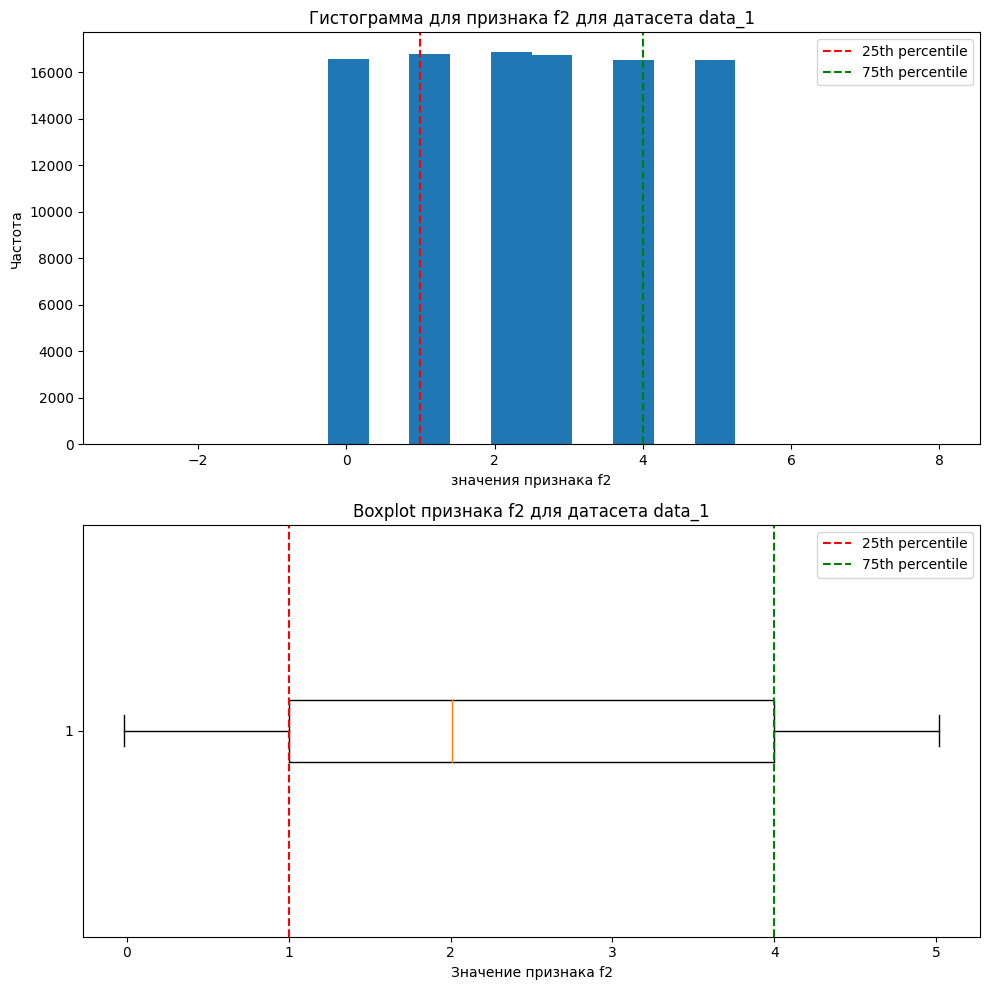

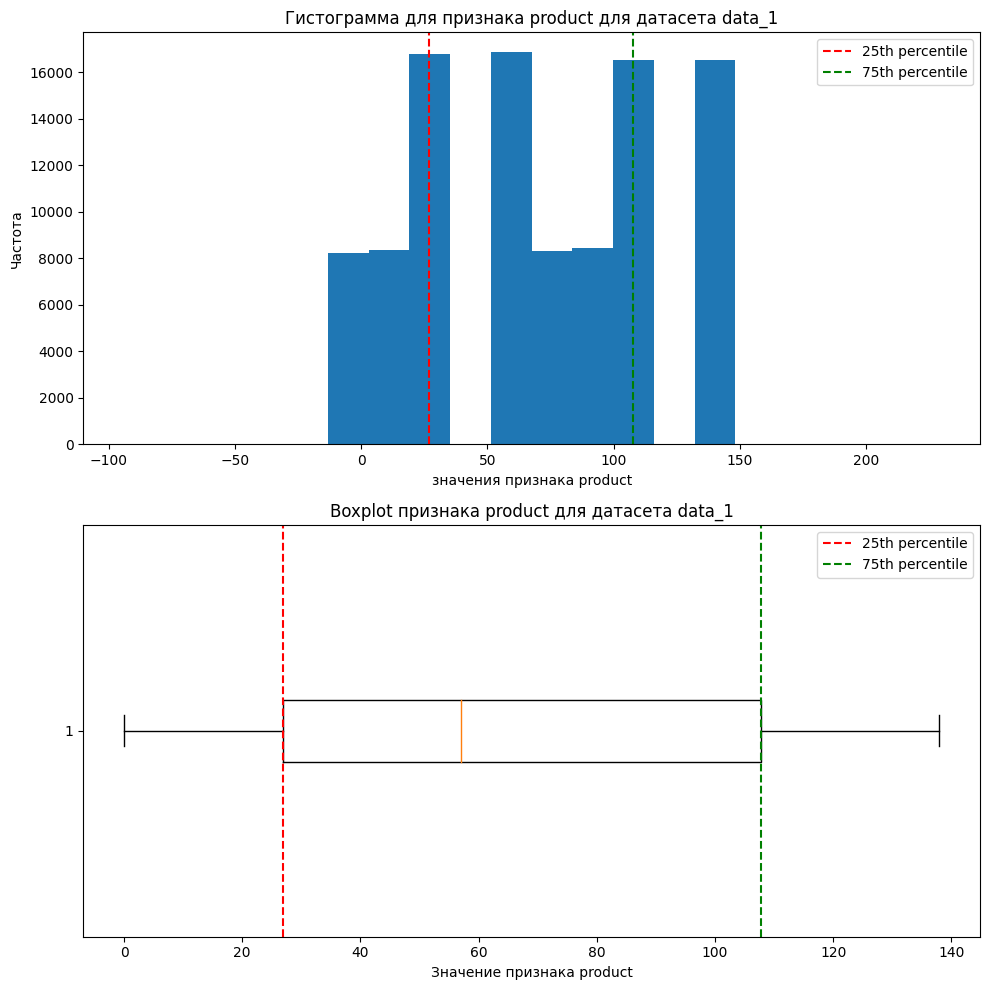

<span style="color:red">Статистический анализ таблицы data_2</span>

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


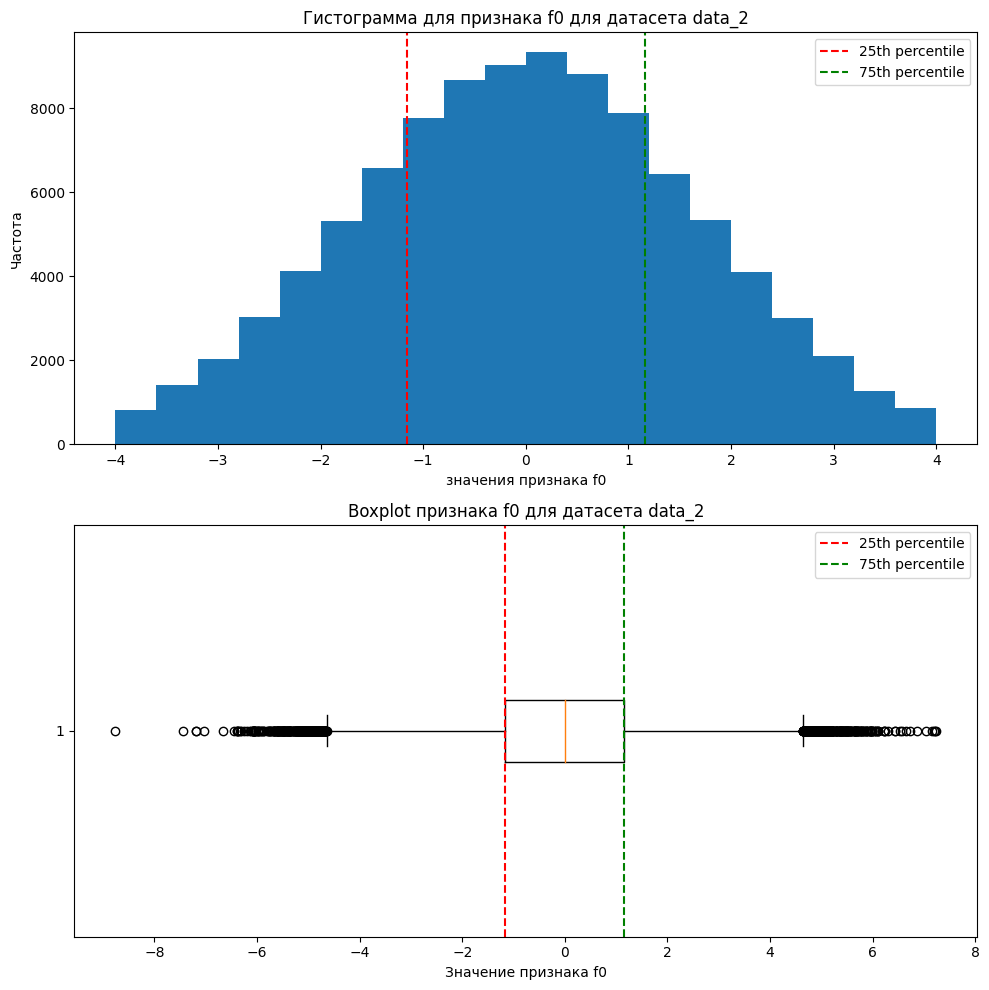

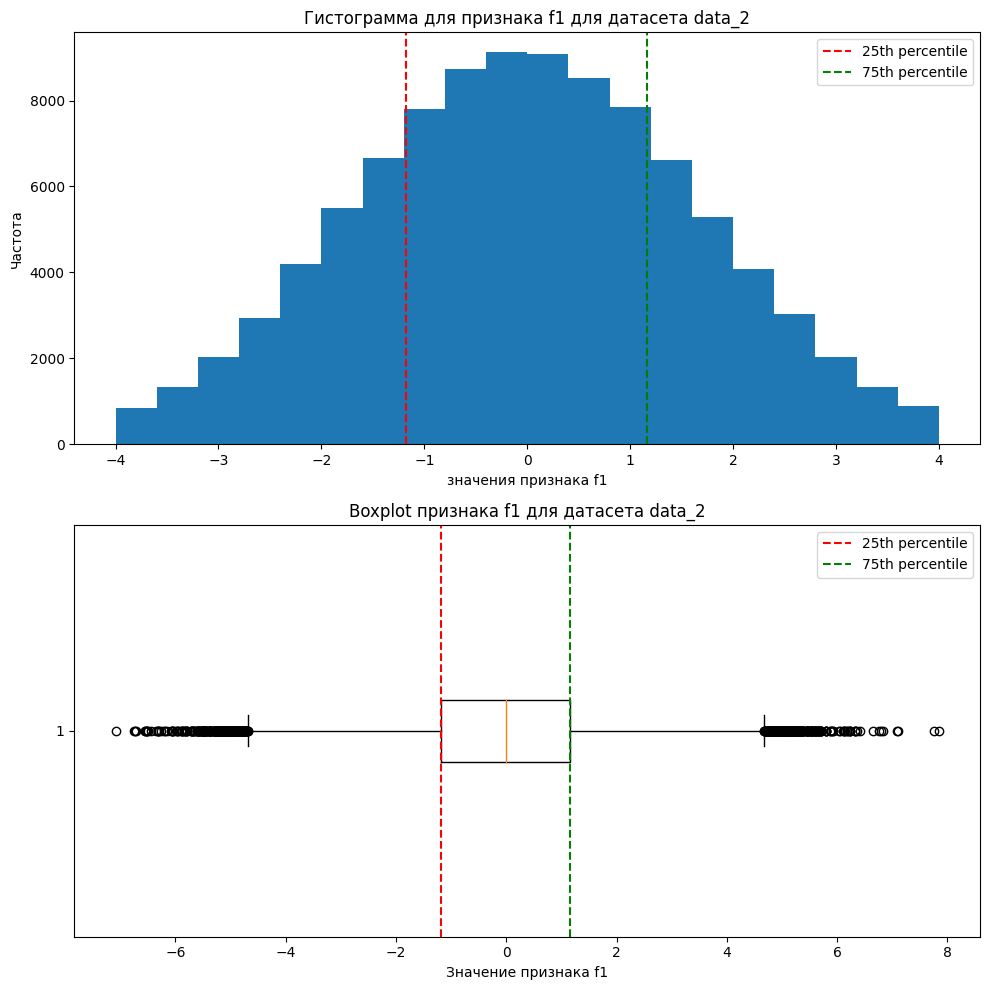

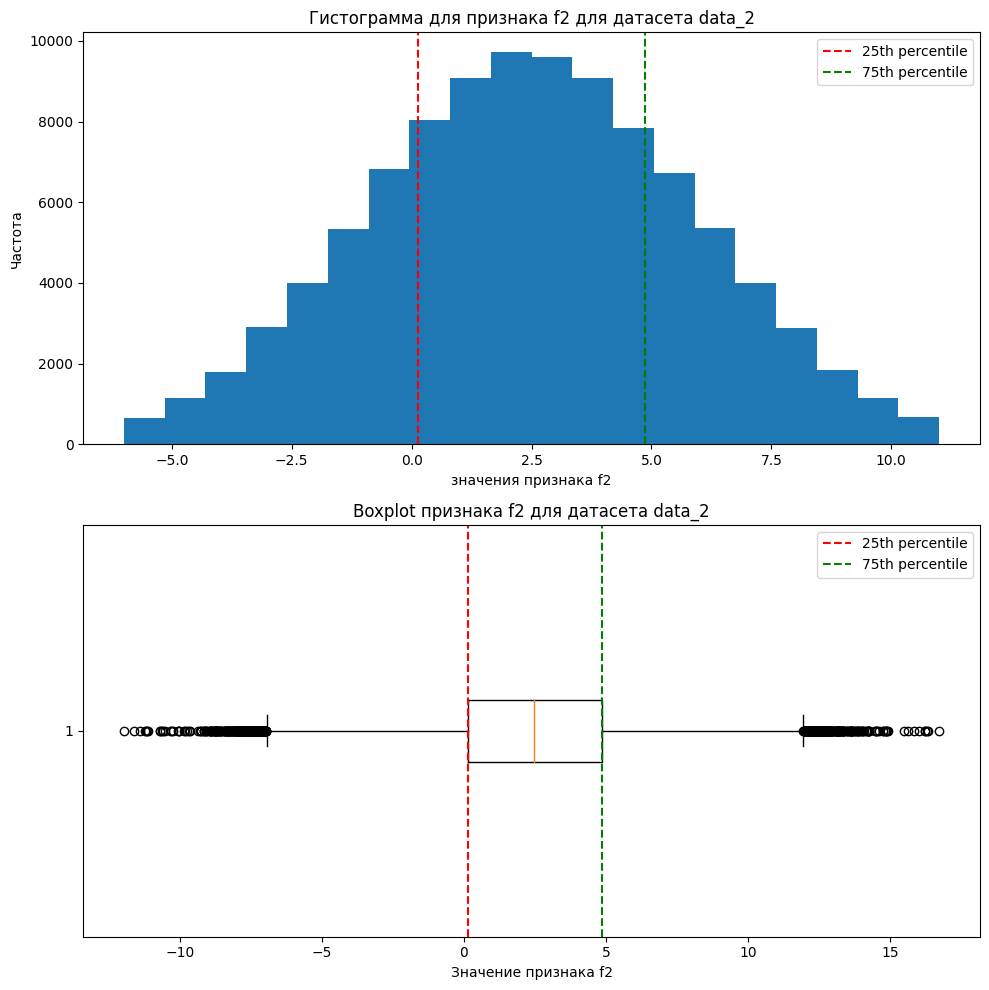

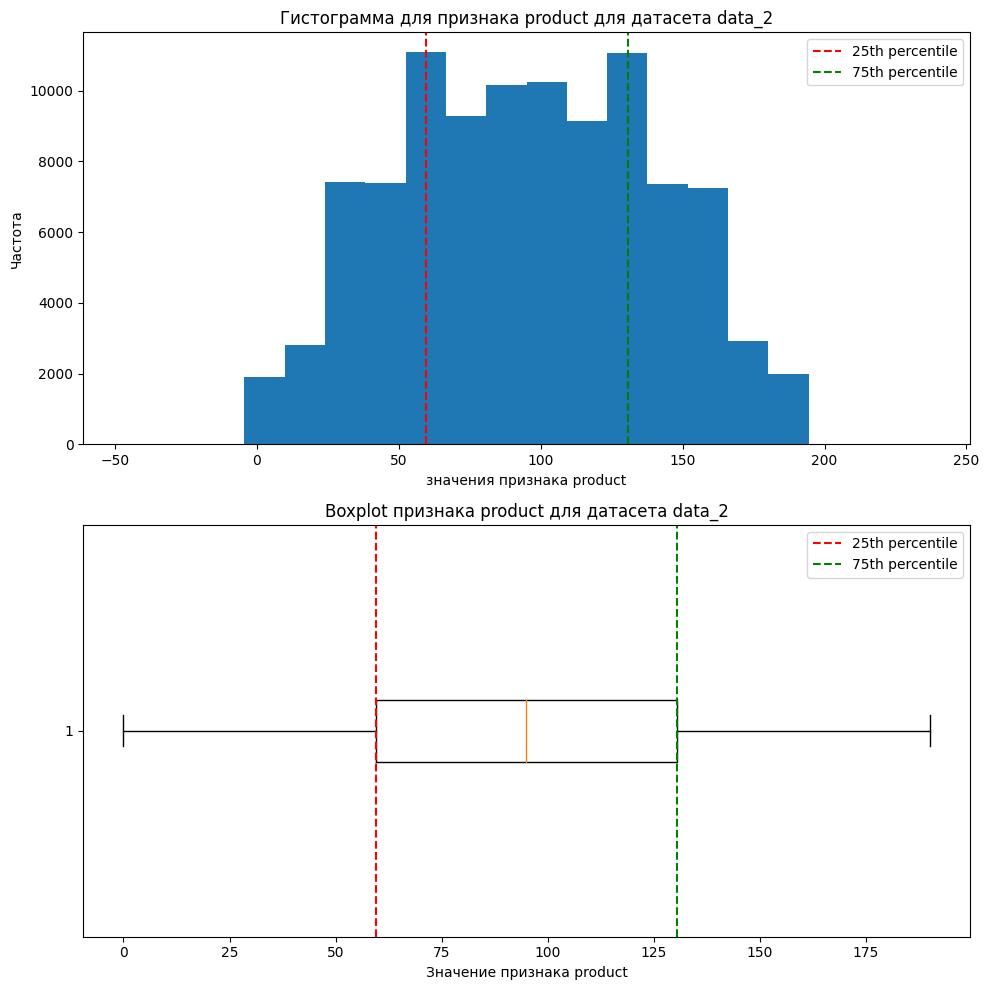

In [15]:
for i in range(3):
    df = globals()[f"data_{i}"]

    # забираем имя датасета
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals
    dataset_name = get_dataset_name(df)

    analysis_df(df, num_list=df.columns.to_list())


Промежуточные выводы по анализу:

1) датасет 0 :
    - данные распределены нормально, много выбросов в признаке f2 - значения менее -6 и более 11
2) датасет 1:
    - признаки f0, f1 распределены нормально, но у признака f1 много выборосов - значения менее -19 и более 9
    - признак f2 скорее дискретный, принимает в основном значения близкие к 0,1,2,3,4 и 5 - по нему построим круговую диаграмму
    - product тоже как будто принимает довольно определенные значения, отсмотрим его отдельно

3) датасет 2:
    - все признаки распределены нормально, большое число выбросов в f0-f2
    - f0 и f1 выбросы менее -4.2 и более 4.6
    - f2 выбросы менее -6 и более 11.5

In [20]:
data_0.query('(f2<-6) | (f2>11)').shape

(751, 4)

выбросы в нулевом датасете занимают всего 0.75% - возможно, стоит их удалить, иначе они исказят предсказания модели

### Пайплайны